<a href="https://colab.research.google.com/github/yskim1230/AIB_Section2-PJT_Modeling-Plan/blob/main/Section_2_Project_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필수 라이브러리 설치

In [ ]:
# 라이브러리 설치
# 원핫인코딩을 위해 category_encoders 라이브러리를 설치해줍니다.
!pip install category_encoders

# for Ridge, Lasso normalize=True options
# 해당 라이브러리 설치 후 런타임 다시 시작 -> 이후 셀 진행
!pip install scikit-learn==1.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import f_regression, SelectKBest

warnings.filterwarnings(action='ignore')



데이터셋 가져오기

In [ ]:
naver_shop = pd.read_csv('https://raw.githubusercontent.com/yskim1230/AIB_Section2-PJT_Modeling-Plan/main/naver_shop_FE_comp.csv')


In [ ]:
naver_shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16426 entries, 0 to 16425
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         16426 non-null  object
 1   Low price     16426 non-null  int64 
 2   Mall Name     16426 non-null  object
 3   Product Type  16426 non-null  int64 
 4   Maker         16426 non-null  object
 5   Brand         16426 non-null  object
 6   category1     16426 non-null  object
 7   category2     16426 non-null  object
 8   category3     16426 non-null  object
 9   Price_range   16425 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.3+ MB


In [ ]:
# 'maker' 컬럼의 카디널리티 확인
maker_cardinality = len(naver_shop['Maker'].unique())
print('maker 카디널리티:', maker_cardinality)

# 'brand' 컬럼의 카디널리티 확인
brand_cardinality = len(naver_shop['Brand'].unique())
print('brand 카디널리티:', brand_cardinality)

# 'category1' 컬럼의 카디널리티 확인
category1_cardinality = len(naver_shop['category1'].unique())
print('category1 카디널리티:', category1_cardinality)

# 'category2' 컬럼의 카디널리티 확인
category2_cardinality = len(naver_shop['category2'].unique())
print('category2 카디널리티:', category2_cardinality)

# 'category3' 컬럼의 카디널리티 확인
category3_cardinality = len(naver_shop['category3'].unique())
print('category3 카디널리티:', category3_cardinality)


# 'Price_range' 컬럼의 카디널리티 확인
Price_range_cardinality = len(naver_shop['Price_range'].unique())
print('Price_range 카디널리티:', Price_range_cardinality)



maker 카디널리티: 427
brand 카디널리티: 891
category1 카디널리티: 2
category2 카디널리티: 5
category3 카디널리티: 18
Price_range 카디널리티: 5


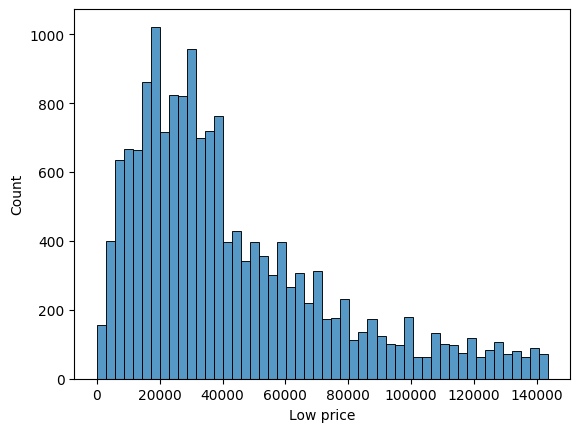

In [ ]:
# 타겟 분포 확인
sns.histplot(naver_shop['Low price'], bins=50);

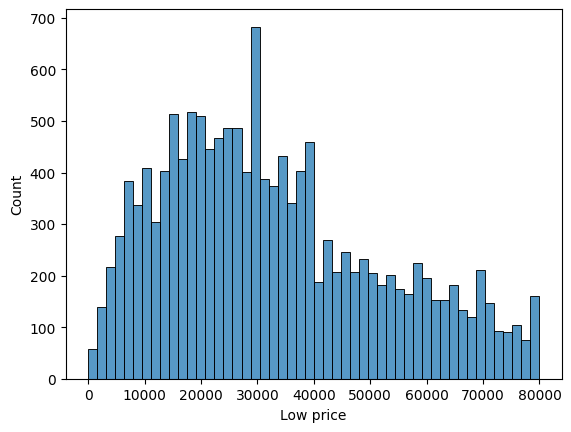

In [ ]:
# 'Low price' 값이 100,000보다 작은 데이터만 추출하여 'naver_shop_cl' 데이터프레임 생성
naver_shop_cl = naver_shop[naver_shop['Low price'] < 80000]

# 'Low price' 컬럼의 히스토그램 그리기
sns.histplot(naver_shop_cl['Low price'], bins=50);

<Axes: xlabel='Price_range_encoded', ylabel='count'>

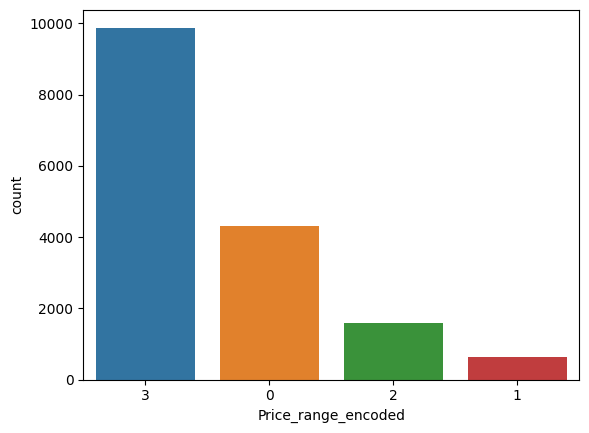

In [ ]:
# 'Price_range' 컬럼을 라벨 인코딩하여 'Price_range_encoded' 변수에 저장
encoder = LabelEncoder()
encoder.fit(['Very Cheap', 'Cheap', 'Moderate', 'Expensive'])  # 순서 지정
naver_shop = naver_shop.dropna(subset=['Price_range'])
naver_shop['Price_range_encoded'] = encoder.transform(naver_shop['Price_range'])

order = naver_shop['Price_range_encoded'].value_counts().index.tolist()
sns.countplot(x='Price_range_encoded', data=naver_shop, order=order)


<Axes: xlabel='Price_range', ylabel='count'>

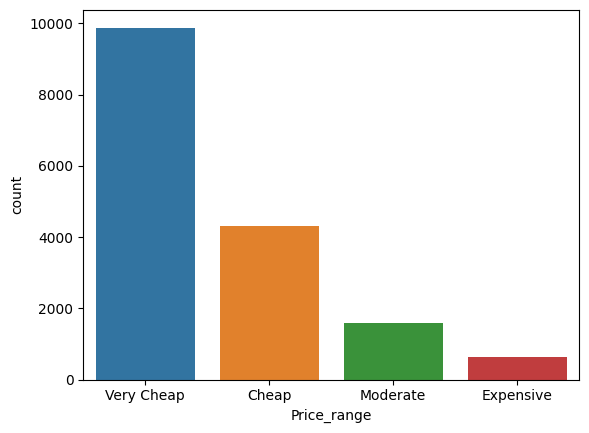

In [ ]:
# 데이터 금액 구간을 나눠 4분류로 했을때
# 'Price_range' 컬럼을 범주형 변수로 변환
naver_shop['Price_range'] = pd.Categorical(naver_shop['Price_range'], categories=['Very Cheap', 'Cheap', 'Moderate', 'Expensive'], ordered=True)

# 'Price_range' 변수의 분포 확인
sns.countplot(x='Price_range', data=naver_shop)

<Axes: >

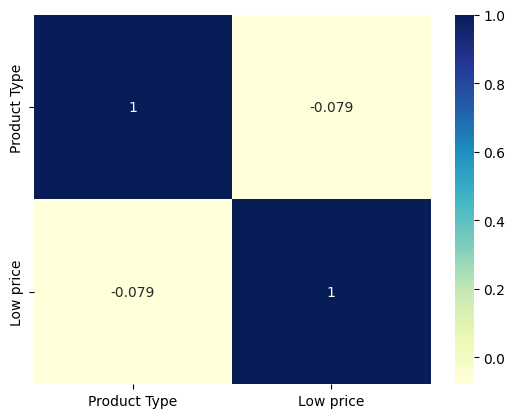

In [ ]:
# 'Product Type'과 'Low price' 간의 상관계수 구하기
corr = naver_shop[['Product Type', 'Low price']].corr()

# 상관도 히트맵 그리기
sns.heatmap(corr, annot=True, cmap='YlGnBu')

# Modeling

In [ ]:
#수치형 변수에 대해서만 스케일링을 적용
scaler = StandardScaler()
naver_shop['Product Type_scaled'] = scaler.fit_transform(naver_shop[['Product Type']])

In [ ]:
# 'Maker', 'Brand', 'category1', 'category2', 'category3' 변수를 원-핫 인코딩하여 'naver_shop_encoded' 데이터프레임 생성
naver_shop_encoded = pd.get_dummies(naver_shop[['category1', 'category2', 'category3']])

# 인코딩 결과를 naver_shop 데이터프레임에 추가
naver_shop = pd.concat([naver_shop, naver_shop_encoded], axis=1)


In [ ]:
# 독립 변수와 타겟 변수를 분리
X = naver_shop.select_dtypes(include=['float', 'int','uint8'])
y = naver_shop['Low price']

# train 데이터와 test 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 기준모델 생성
baseline = [y_train.mean()] * len(y_train)
baseline_r2 = r2_score(y_train, baseline)
baseline_mae = mean_absolute_error(y_train, baseline)
print(f'기준모델의 r2_score: {baseline_r2}')
print(f'기준모델의 mae : {baseline_mae}')

기준모델의 r2_score: 0.0
기준모델의 mae : 25255.417798685965


In [ ]:
def print_score(model, X_train, y_train, X_test, y_test) :

    train_score = np.round(model.score(X_train, y_train) , 3)
    val_score = np.round(np.mean(cross_val_score(model, X_train, y_train, scoring='r2', cv=3).round(3)),3)
    test_score = np.round(model.score(X_test, y_test),3)
    print(f'학습 세트 r2_score : {train_score}')
    print(f'검증 세트 r2_score : {val_score}')
    print(f'테스트 세트 r2_score : {test_score}')

    return train_score, val_score, test_score

In [ ]:
# 선형회귀를 ols라는 객체에 저장합니다. 
ols = LinearRegression()

# 모델 학습
ols.fit(X_train, y_train)

# 성능 비교
ols_train, ols_val, ols_test = print_score(ols,X_train, y_train, X_test, y_test)

학습 세트 r2_score : 1.0
검증 세트 r2_score : 1.0
테스트 세트 r2_score : 1.0


과적합이 발생해버렸다.

In [ ]:
selector = SelectKBest(score_func= f_regression, k='all')

# 학습 데이터에 fit_transform
X_train_selected = selector.fit_transform(X_train, y_train)

# 테스트 데이터는 transform
X_test_selected = selector.transform(X_test)

# 어떤 특성이 선택되었는지 확인해봅시다.
selector.get_feature_names_out()

array(['Low price', 'Product Type', 'Price_range_encoded', ...,
       'category3_트레이닝복', 'category3_티셔츠', 'category3_팬티'], dtype=object)